
🔍 Analyzing Text (Positive): I really enjoyed the product. It exceeded my expectations!


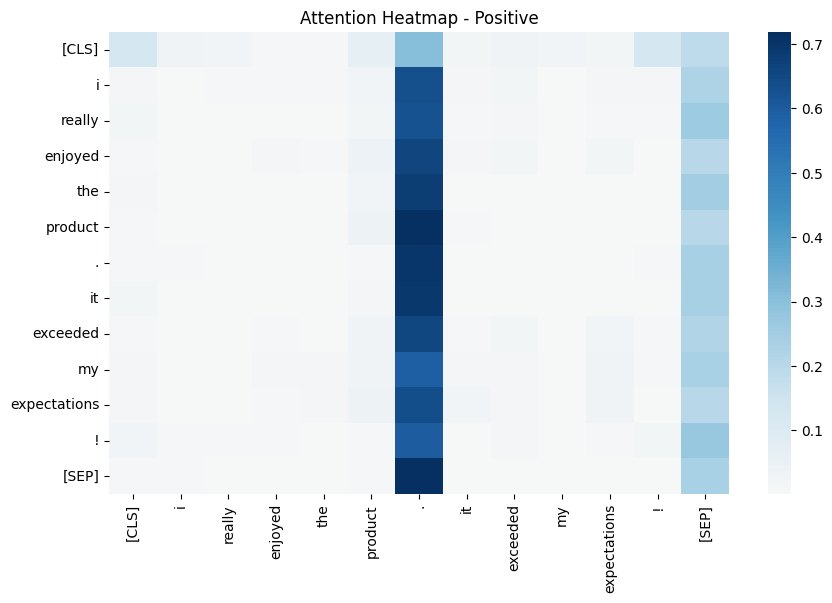

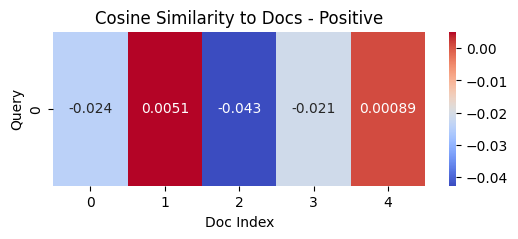

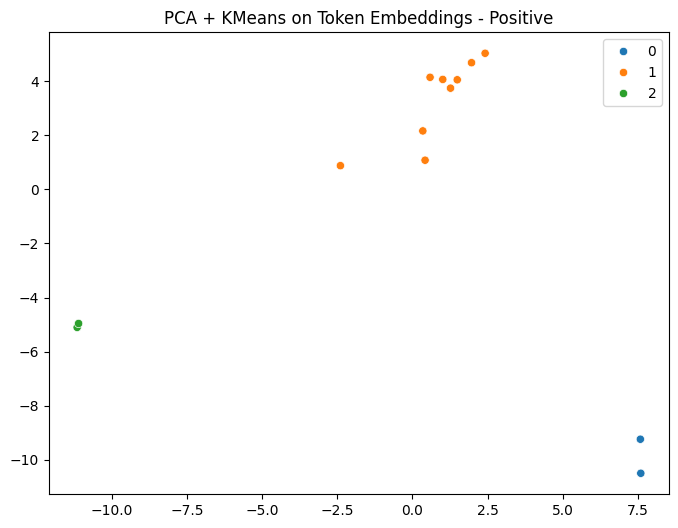

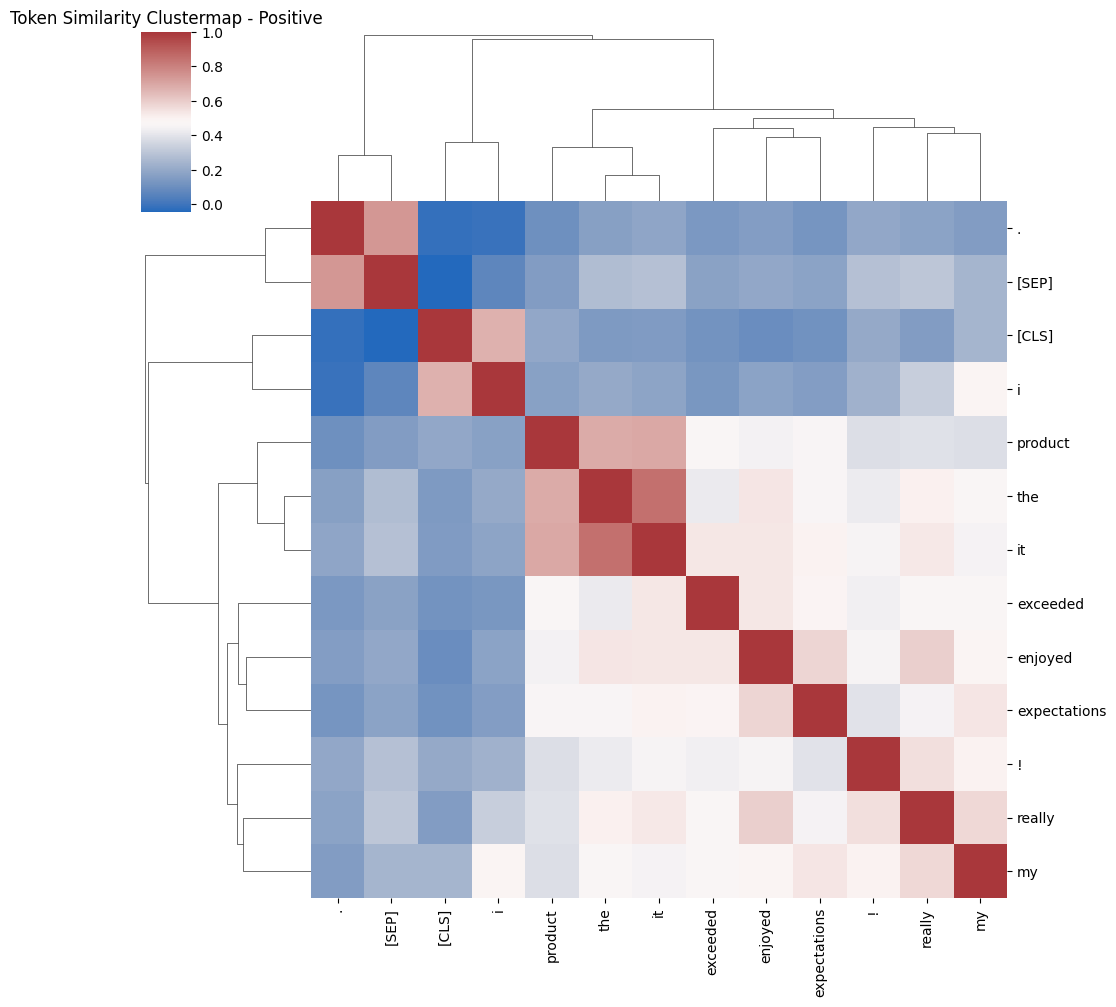


🔍 Analyzing Text (Negative): This product is terrible. I'm very disappointed and frustrated.


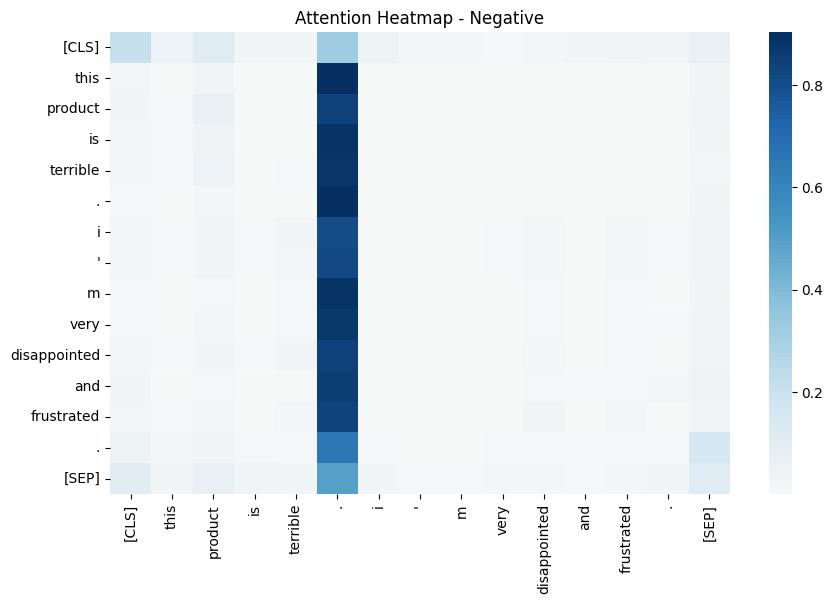

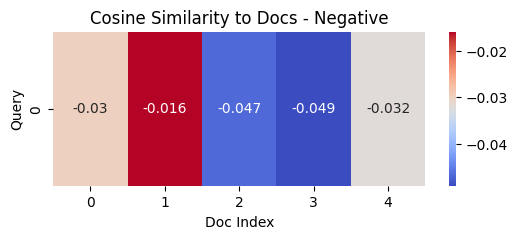

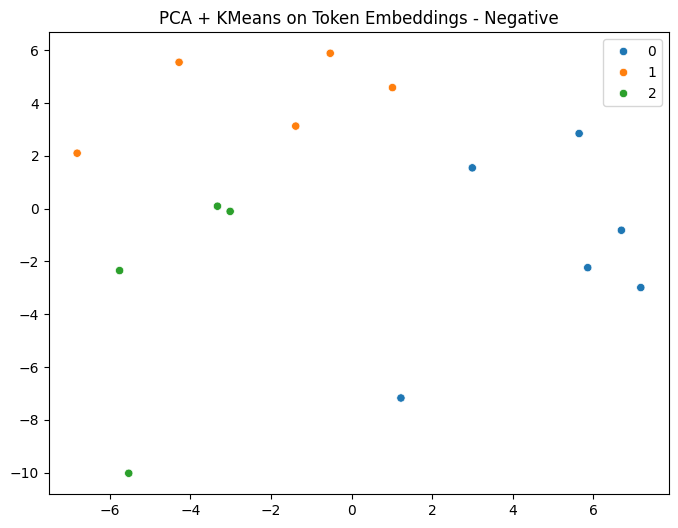

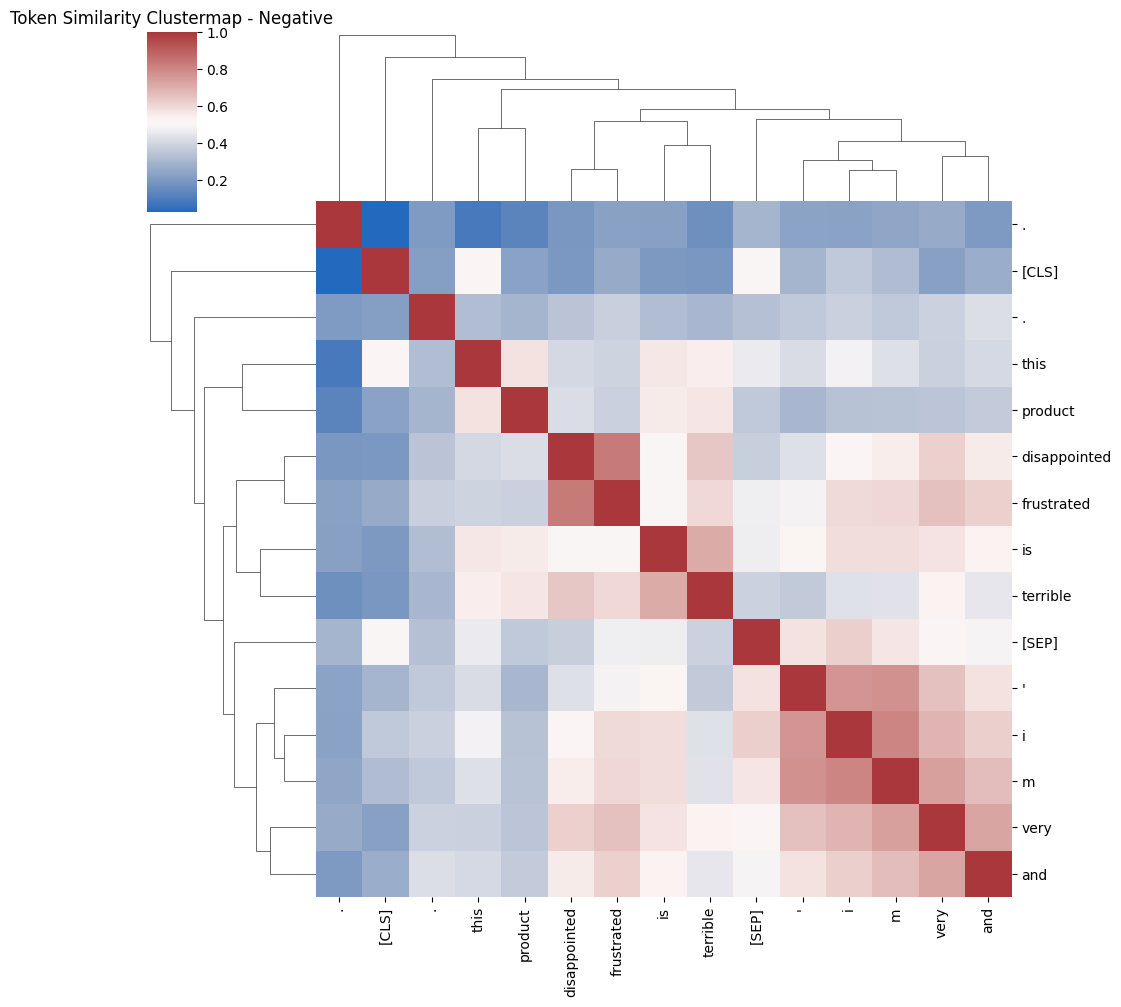

In [5]:
import torch
from transformers import AutoTokenizer, AutoModel
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
import plotly.express as px

# Load model and tokenizer
model_name = "bert-base-uncased"
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModel.from_pretrained(model_name, output_attentions=True)
model.eval()

def visualize_text(text, label=""):
    print(f"\n🔍 Analyzing Text ({label}): {text}")

    # Tokenize and pass through model
    inputs = tokenizer(text, return_tensors="pt")
    with torch.no_grad():
        outputs = model(**inputs)
        attentions = outputs.attentions[-1][0][0]  # last layer, first head
        embeddings = outputs.last_hidden_state[0]

    tokens = tokenizer.convert_ids_to_tokens(inputs["input_ids"][0])
    emb_array = embeddings.numpy()

    #Attention Heatmap (Red/Blue)
    plt.figure(figsize=(10, 6))
    sns.heatmap(attentions.numpy(), xticklabels=tokens, yticklabels=tokens, cmap='RdBu', center=0)
    plt.title(f"Attention Heatmap - {label}")
    plt.show()

    #Cosine Similarity
    doc_embeddings = torch.rand((5, embeddings.shape[1]))
    query_embedding = embeddings.mean(dim=0).numpy().reshape(1, -1)
    doc_vectors = doc_embeddings.numpy()
    cos_sim = cosine_similarity(query_embedding, doc_vectors)

    plt.figure(figsize=(6, 2))
    sns.heatmap(cos_sim, annot=True, cmap='coolwarm')
    plt.title(f"Cosine Similarity to Docs - {label}")
    plt.xlabel("Doc Index")
    plt.ylabel("Query")
    plt.show()

    #PCA + KMeans
    pca = PCA(n_components=2)
    reduced = pca.fit_transform(emb_array)
    kmeans = KMeans(n_clusters=3)
    labels = kmeans.fit_predict(reduced)

    plt.figure(figsize=(8, 6))
    sns.scatterplot(x=reduced[:, 0], y=reduced[:, 1], hue=labels, palette='tab10')
    plt.title(f"PCA + KMeans on Token Embeddings - {label}")
    plt.show()

    #3D Embedding Plot
    pca_3d = PCA(n_components=3)
    reduced_3d = pca_3d.fit_transform(emb_array)
    fig = px.scatter_3d(
        x=reduced_3d[:, 0], y=reduced_3d[:, 1], z=reduced_3d[:, 2],
        text=tokens, title=f"3D Embedding Scatter - {label}"
    )
    fig.show()

    #Clustermap
    sim_matrix = cosine_similarity(emb_array)
    sns.clustermap(sim_matrix, cmap='vlag', xticklabels=tokens, yticklabels=tokens)
    plt.title(f"Token Similarity Clustermap - {label}")
    plt.show()


#Visualize Positive Comment
positive_text = "I really enjoyed the product. It exceeded my expectations!"
visualize_text(positive_text, label="Positive")

#Visualize Negative Comment
negative_text = "This product is terrible. I'm very disappointed and frustrated."
visualize_text(negative_text, label="Negative")
